In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import csv
import os
import keras
from tensorflow.python.client import device_lib
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Input, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
import datetime

In [300]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("solution_submission.csv")

In [301]:
train = train.drop(['FTHG', "FTAG", "Season", 'HomeTeam', 'AwayTeam', "Referee", "DateTime", "HTHG"	,"HTAG"], axis = 1)
test = test.drop(["FTR", "ID", "Season", 'HomeTeam', 'AwayTeam', "Referee", "DateTime", "HTHG"	,"HTAG"],axis=1)

In [302]:
train

,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTR,FTR
0,17,8,14,4,6,6,13,12,1,2,0,0,H,H
1,17,12,10,5,7,7,19,14,1,2,0,0,H,H
2,6,16,3,9,8,4,15,21,5,3,1,0,D,A
3,6,13,4,6,5,8,11,13,1,1,0,0,A,D
4,17,12,8,6,6,4,21,20,1,3,0,0,H,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7595,14,7,3,3,3,3,12,11,1,4,1,0,D,A
7596,31,5,10,4,9,0,7,4,1,1,0,0,H,H
7597,3,14,2,6,2,4,11,5,1,0,0,0,D,A
7598,13,5,4,3,9,1,9,16,0,1,0,0,A,H


In [303]:
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()


In [304]:
train_numerics = train.select_dtypes(include = ['float64', 'int64']).drop([ "HTR", "FTR"], axis=1, errors= 'ignore')
test_numerics = test.select_dtypes(include = ['float64', 'int64']).drop(["HTR"], axis=1, errors= 'ignore')

standrdized_train_data = min_max_scaler.fit_transform(train_numerics)
standrdized_test_data = min_max_scaler.fit_transform(test_numerics)

standrdized_train_df = pd.DataFrame(standrdized_train_data, columns=train_numerics.columns)
standrdized_test_df = pd.DataFrame(standrdized_test_data, columns=test_numerics.columns)

standrdized_train_df['HTR'] = train['HTR']
standrdized_train_df['FTR'] = train["FTR"]

standrdized_test_df['HTR'] = test['HTR']

In [305]:
type(standrdized_test_df)

pandas.core.frame.DataFrame

In [306]:
standrdized_train_df.loc[standrdized_train_df["HTR"]=="H", "HTR"]=0
standrdized_train_df.loc[standrdized_train_df["HTR"]=="D", "HTR"]=1
standrdized_train_df.loc[standrdized_train_df["HTR"]=="A", "HTR"]=2

standrdized_train_df.loc[standrdized_train_df["FTR"]=="H", "FTR"]=0
standrdized_train_df.loc[standrdized_train_df["FTR"]=="D", "FTR"]=1
standrdized_train_df.loc[standrdized_train_df["FTR"]=="A", "FTR"]=2

standrdized_test_df.loc[standrdized_test_df['HTR']=="H", "HTR"]=0
standrdized_test_df.loc[standrdized_test_df['HTR']=="D", "HTR"]=1
standrdized_test_df.loc[standrdized_test_df['HTR']=="A", "HTR"]=2


In [307]:
standrdized_train_df

,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTR,FTR
0,0.395349,0.266667,0.583333,0.20,0.30,0.315789,0.393939,0.392857,0.142857,0.222222,0.000000,0.0,0,0
1,0.395349,0.400000,0.416667,0.25,0.35,0.368421,0.575758,0.464286,0.142857,0.222222,0.000000,0.0,0,0
2,0.139535,0.533333,0.125000,0.45,0.40,0.210526,0.454545,0.714286,0.714286,0.333333,0.333333,0.0,1,2
3,0.139535,0.433333,0.166667,0.30,0.25,0.421053,0.333333,0.428571,0.142857,0.111111,0.000000,0.0,2,1
4,0.395349,0.400000,0.333333,0.30,0.30,0.210526,0.636364,0.678571,0.142857,0.333333,0.000000,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7595,0.325581,0.233333,0.125000,0.15,0.15,0.157895,0.363636,0.357143,0.142857,0.444444,0.333333,0.0,1,2
7596,0.720930,0.166667,0.416667,0.20,0.45,0.000000,0.212121,0.107143,0.142857,0.111111,0.000000,0.0,0,0
7597,0.069767,0.466667,0.083333,0.30,0.10,0.210526,0.333333,0.142857,0.142857,0.000000,0.000000,0.0,1,2
7598,0.302326,0.166667,0.166667,0.15,0.45,0.052632,0.272727,0.535714,0.000000,0.111111,0.000000,0.0,2,0


In [308]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(standrdized_train_df, label="FTR")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(standrdized_test_df)

In [309]:
df_split_train, df_split_train_ev = train_test_split(standrdized_train_df, test_size=0.2, random_state=20)


In [310]:
df_split_train_target = pd.DataFrame()
df_split_train_ev_target = pd.DataFrame()

df_split_train_target['FTR'] = df_split_train["FTR"]
df_split_train_ev_target['FTR'] = df_split_train_ev["FTR"]



In [311]:
df_split_train = df_split_train.drop(["FTR"], axis=1)
df_split_train_ev = df_split_train_ev.drop(["FTR"], axis=1)

In [312]:
df_split_train.shape

(6080, 13)

In [313]:
df_split_train = df_split_train.astype(float)
df_split_train_ev = df_split_train_ev.astype(float)
df_split_train_target = df_split_train_target.astype(float)
df_split_train_ev_target = df_split_train_ev_target.astype(float)

standrdized_test_df = standrdized_test_df.astype(float)

In [314]:
tuner = tfdf.tuner.RandomSearch(
    num_trials=100, 
    use_predefined_hps = True,
    trial_num_threads = 1,
    trial_maximum_training_duration_seconds= None
)

rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION, hyperparameter_template="benchmark_rank1")
rf.compile(metrics=["accuracy"])
rf_his =rf.fit(x = train_ds, verbose=2)

print(rf.summary())

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmp4q1y78ws as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'HS': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'AS': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'HST': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'AST': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'HC': <tf.Tensor 'data_4:0' shape=(None,) dtype=float64>, 'AC': <tf.Tensor 'data_5:0' shape=(None,) dtype=float64>, 'HF': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, 'AF': <tf.Tensor 'data_7:0' shape=(None,) dtype=float64>, 'HY': <tf.Tensor 'data_8:0' shape=(None,) dtype=float64>, 'AY': <tf.Tensor 'data_9:0' shape=(None,) dtype=float64>, 'HR': <tf.Tensor 'data_10:0' shape=(Non

Training dataset read in 0:00:00.256823. Found 7600 examples.
Training model...


[INFO 24-02-28 23:21:53.4029 KST kernel.cc:773] Start Yggdrasil model training
[INFO 24-02-28 23:21:53.4029 KST kernel.cc:774] Collect training examples
[INFO 24-02-28 23:21:53.4029 KST kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 24-02-28 23:21:53.4030 KST kernel.cc:393] Number of batches: 8
[INFO 24-02-28 23:21:53.4030 KST kernel.cc:394] Number of examples: 7600
[INFO 24-02-28 23:21:53.4036 KST kernel.cc:794] Training dataset:
Number of records: 7600
Number of columns: 14

Number of columns by type:
	NUMERICAL: 13 (92.8571%)
	CATEGORICAL: 1 (7.14286%)

Columns:

NUMERICAL: 13 (92.8571%)
	0: "AC" NUMERICAL mean:0.251981 min:0 max:1 sd:0.143711

Model trained in 0:00:03.909509
Compiling model...


Model compiled.


Model: "random_forest_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (13):
	AC
	AF
	AR
	AS
	AST
	AY
	HC
	HF
	HR
	HS
	HST
	HTR
	HY

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "AST"  0.206292 ################
    2. "HTR"  0.161067 ##########
    3.  "AS"  0.153073 #########
    4.  "AC"  0.148785 ########
    5.  "AF"  0.146929 ########
    6.  "AR"  0.132093 ######
    7. "HST"  0.126234 #####
    8.  "HF"  0.105559 ###
    9.  "AY"  0.104860 ##
   10.  "HS"  0.102748 ##
   11.  "HC"  0.102359 ##
   12.  "HR"  0.094943 #
   13.  "HY"  0.081764 

Variable Importance: NUM_AS_ROOT:
    1. "HTR" 81.000000 ################
    2. "AST" 35.000000 ##

In [91]:
standrdized_test_df

,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTHG,HTAG,HTR
0,-1.487567,0.296152,-0.995348,0.776790,-1.192151,-0.644948,0.356330,0.437559,0.377970,0.337966,-0.227834,-0.250533,-0.808251,0.501623,2.0
1,-1.487567,-0.494735,-0.611579,0.366354,0.482792,-0.644948,0.925963,0.157895,0.377970,-0.493671,-0.227834,-0.250533,0.397128,-0.732728,0.0
2,1.575163,-1.087900,0.539727,-0.454517,1.152769,-1.752181,-0.498118,-1.240427,-0.459398,-1.325308,-0.227834,-0.250533,2.807884,1.735974,0.0
3,0.314039,0.691595,-0.611579,-0.864953,0.817781,0.831362,0.641146,-0.960763,0.377970,0.337966,-0.227834,-0.250533,-0.808251,-0.732728,1.0
4,-1.127246,0.296152,-1.379117,1.187226,-1.192151,0.093207,0.356330,-0.401434,-0.459398,-0.493671,-0.227834,-0.250533,-0.808251,-0.732728,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,-0.766925,-0.099291,1.307265,0.366354,1.152769,-0.644948,0.356330,0.996888,0.377970,1.169603,-0.227834,-0.250533,-0.808251,0.501623,2.0
685,0.314039,-1.285621,0.923496,-1.275389,-0.522174,0.462284,-2.491832,-1.240427,-1.296766,-0.493671,-0.227834,-0.250533,-0.808251,-0.732728,1.0
686,-0.226443,-0.099291,-0.611579,-0.454517,-0.857162,-0.275871,0.071514,0.437559,-0.459398,-0.493671,-0.227834,-0.250533,1.602506,-0.732728,0.0
687,0.674360,1.284761,0.539727,-0.044082,0.147803,0.831362,0.356330,-0.121770,-0.459398,-0.493671,-0.227834,-0.250533,0.397128,-0.732728,0.0


In [236]:
df_split_train

,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HTR
7446,-1.247757,1.861951,-1.269863,-0.294172,-1.654436,1.908935,-0.640526,0.503545,-0.339952,-0.597697,-0.249877,-0.304949,1.0
5558,-0.865380,-0.787521,-0.971451,-0.649383,-0.364229,1.176472,0.674083,1.260306,0.501898,1.760410,-0.249877,-0.304949,1.0
2193,-1.247757,-0.125153,-1.568276,-0.294172,-0.041677,0.810240,0.148240,0.503545,0.501898,-1.383733,-0.249877,-0.304949,1.0
4074,0.664129,0.316426,1.415850,1.126676,-0.041677,1.176472,-0.377604,-1.009977,-1.181802,-0.597697,-0.249877,-0.304949,0.0
3356,-0.483003,0.978794,-0.374626,1.126676,-0.041677,0.077776,0.937005,1.008052,1.343748,0.974374,-0.249877,-0.304949,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7068,-0.291814,0.758005,-0.673038,0.061040,0.280875,1.908935,-0.377604,-1.009977,0.501898,0.974374,-0.249877,-0.304949,0.0
7391,1.046506,1.420373,-0.076213,1.126676,0.280875,0.077776,1.199927,0.755799,0.501898,-0.597697,-0.249877,-0.304949,2.0
4367,-1.056569,3.186687,-0.374626,2.192312,-1.654436,1.908935,-1.166370,-1.514485,-0.339952,-0.597697,-0.249877,-0.304949,1.0
2522,-0.100626,0.978794,-0.076213,1.481888,-0.686780,1.542703,-0.114682,-1.009977,-0.339952,-0.597697,-0.249877,-0.304949,1.0


In [25]:
initializer1 = tf.keras.initializers.HeNormal()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [415]:
def epl_multi_class():
    inputs = Input(shape=(13,))
    x = Dense(128, activation = 'elu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(64, activation = 'elu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation = 'elu', kernel_initializer = initializer1)(x)
    x = Dropout(0.4)(x)
    x = Dense(16, activation = 'elu')(x)
    x = Dropout(0.3)(x)
    x = Dense(8, activation = 'elu')(x)
    x = Dense(4, activation = 'elu')(x)
    
    output = Dense(3, activation = 'softmax', kernel_initializer='glorot_uniform')(x)
    model = Model(inputs = inputs, outputs = output, name = 'epl')
    model.compile(optimizer = 'RMSprop', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model
model = epl_multi_class()
model.summary()

Model: "epl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_103 (InputLayer)      [(None, 13)]              0         
                                                                 
 dense_376 (Dense)           (None, 128)               1792      
                                                                 
 dropout_260 (Dropout)       (None, 128)               0         
                                                                 
 dense_377 (Dense)           (None, 64)                8256      
                                                                 
 dropout_261 (Dropout)       (None, 64)                0         
                                                                 
 dense_378 (Dense)           (None, 32)                2080      
                                                                 
 dropout_262 (Dropout)       (None, 32)                0       

/home/arin/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [416]:
his = model.fit(df_split_train, df_split_train_target, epochs=100, verbose=2,  validation_data=(df_split_train_ev, df_split_train_ev_target), callbacks=[early_stopping])

Epoch 1/100
190/190 - 3s - loss: 0.9357 - accuracy: 0.5653 - val_loss: 0.8353 - val_accuracy: 0.6026 - 3s/epoch - 14ms/step
Epoch 2/100
190/190 - 1s - loss: 0.8527 - accuracy: 0.6137 - val_loss: 0.8074 - val_accuracy: 0.6329 - 1s/epoch - 7ms/step
Epoch 3/100
190/190 - 1s - loss: 0.8319 - accuracy: 0.6273 - val_loss: 0.8016 - val_accuracy: 0.6336 - 1s/epoch - 7ms/step
Epoch 4/100
190/190 - 1s - loss: 0.8206 - accuracy: 0.6326 - val_loss: 0.8139 - val_accuracy: 0.6230 - 1s/epoch - 8ms/step
Epoch 5/100
190/190 - 1s - loss: 0.8147 - accuracy: 0.6405 - val_loss: 0.7951 - val_accuracy: 0.6375 - 1s/epoch - 7ms/step
Epoch 6/100
190/190 - 1s - loss: 0.8174 - accuracy: 0.6354 - val_loss: 0.7897 - val_accuracy: 0.6401 - 1s/epoch - 7ms/step
Epoch 7/100
190/190 - 1s - loss: 0.8072 - accuracy: 0.6406 - val_loss: 0.8201 - val_accuracy: 0.6171 - 1s/epoch - 7ms/step
Epoch 8/100
190/190 - 1s - loss: 0.8076 - accuracy: 0.6375 - val_loss: 0.7911 - val_accuracy: 0.6408 - 1s/epoch - 7ms/step
Epoch 9/100
190

<Axes: >

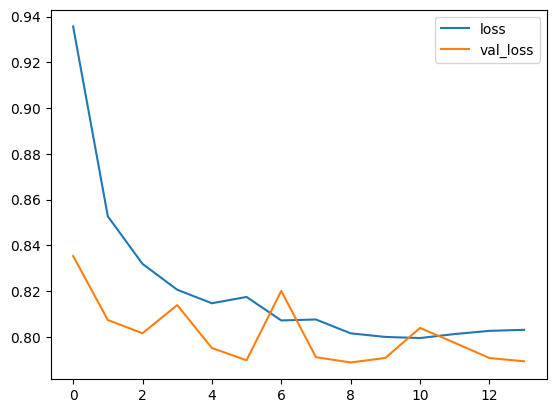

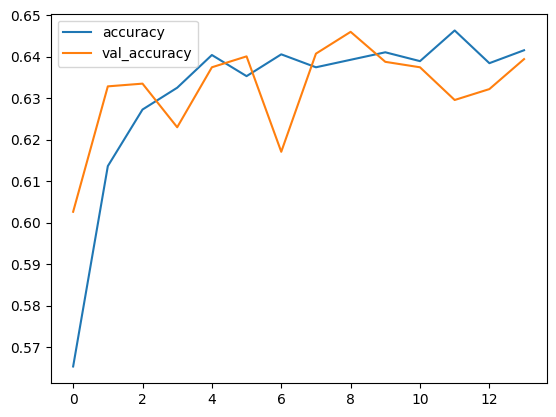

In [417]:
df_his = pd.DataFrame(his.history)
df_his[["loss",  "val_loss"]].plot()
df_his[["accuracy", "val_accuracy"]].plot()

In [419]:
predictions = model.predict(standrdized_test_df)

22/22 [==============================] - 0s 3ms/step


In [237]:
predictions = rf.predict(test_ds)

1/1 [==============================] - 0s 171ms/step


In [420]:
predicted_classes = np.argmax(predictions, axis=1)

In [243]:
predicted_classes

array([2, 0, 0, 1, 2, 0, 2, 2, 0, 0, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 0, 2,
       2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 1, 2, 0, 2, 0, 0, 2, 0, 0,
       0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 2, 1, 1, 0,
       0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0,
       2, 1, 0, 1, 0, 0, 1, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0,
       2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 1, 0, 2, 0, 2, 2, 0, 1, 0, 1, 2, 0,
       0, 2, 0, 0, 0, 2, 2, 1, 2, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 2, 0, 2,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 1, 0, 0,
       2, 1, 2, 0, 1, 2, 0, 2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 0, 1, 0, 1, 0,
       0, 1, 1, 2, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1, 2, 0, 1, 2, 0,
       0, 2, 2, 0, 1, 0, 1, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0,
       2, 0, 2, 1, 0, 1, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 1, 0, 1, 0, 2,
       0, 0, 0, 2, 2, 0, 1, 2, 0, 2, 1, 2, 0, 2, 1,

In [240]:
a = []
for i in predictions :
    i = i.tolist()
    if i.index(max(i)) == 0 :
        a.append('H')
    elif i.index(max(i))==1:
        a.append('D')
    elif i.index(max(i))==2:
        a.append('A')

In [421]:
b = []
for i in predicted_classes :
    if i == 0 :
        b.append('H')
    elif i == 1 :
        b.append("D")
    elif i ==2 :
        b.append("A")

In [422]:
sub['FTR'] = b
sub.to_csv('submission.csv', index=False)
sub.head()

,ID,FTR
0,1,A
1,2,H
2,3,H
3,4,D
4,5,A
